# Assignment 2: Transformer Architecture Exercise


## 1) Dataset Preparation

*   Chosen Dataset: WikiText-2, tasked with language modeling and coherent text generation.
*   Reason for choosing this dataset: I chose the WikiText-2 dataset to explore how different Transformer architectures perform on a foundational generative task. While the reference notebook focused on summarization, I was interested in evaluating the models' abilities to generate high-quality, coherent text from scratch. WikiText-2, being a clean and well-structured corpus of featured Wikipedia articles, provides an ideal environment for this comparison.

In [52]:
# Setting up the Environment
import torch
import time
from datasets import load_dataset
from transformers import (
AutoTokenizer,
AutoModelForCausalLM,
AutoModelForMaskedLM,
AutoModelForSeq2SeqLM,
DataCollatorForLanguageModeling,
DataCollatorForSeq2Seq,
Trainer,
TrainingArguments,
logging)


logging.set_verbosity_info() # This code silences the warnings and other informational message but only shows the error messages
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Models will be trained on:", device)

Models will be trained on: cuda


In [53]:
# Loading the dataset
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
dataset = dataset.filter(lambda example: len(example['text'].strip()) > 0)

training_size = 1000
validation_size = 200
train_dataset = dataset["train"].shuffle(seed = 42).select(range(training_size))
test_dataset = dataset["test"].shuffle(seed = 42).select(range(validation_size))

print("sample Record: ", train_dataset[0])
print('sample test data record', test_dataset[56])

sample Record:  {'text': " The ship 's primary armament consisted of four 30 @.@ 5 cm ( 12 in ) 45 @-@ caliber guns in two twin gun turrets . This was augmented by a heavy secondary battery of eight 24 cm ( 9 @.@ 4 in ) guns in four wing turrets . The tertiary battery consisted of twenty 10 cm L / 50 guns in casemated single mounts , four 47 mm ( 1 @.@ 85 in ) L / 44 and one 47 mm L / 33 quick @-@ firing guns . Furthermore , the ship 's boats were equipped with two 66 mm ( 2 @.@ 6 in ) landing guns for operations shore . Three 45 cm ( 17 @.@ 7 in ) torpedo tubes were also carried , one on each broadside and one in the stern . \n"}
sample test data record {'text': ' Traditional Chinese literary criticism emphasized the life of the author when interpreting a work , a practice which Burton Watson attributes to " the close links that traditional Chinese thought posits between art and morality " . Since many of Du Fu \'s poems feature morality and history , this practice is particularly imp

#### Dataset Processing Documentation:
- The WikiText-2 (wikitext-2-raw-v1) dataset was loaded from the Hugging Face datasets library. For efficient experimentation, the data was then shuffled and split into a smaller subset, consisting of 1000 samples for the training set and 200 for the test set.

- A cleaning step was applied using the .filter() method to remove any records containing only whitespace. This ensures that every entry in the dataset has meaningful text content, which is crucial for stable model training.

### 2) Model Implementation
- **Decoder-only**: GPT-2 small (124M parameters) for causal language modeling
- **Encoder-only**: BERT-base-uncased (110M parameters) for masked language modeling  
- **Encoder-decoder**: T5-small (60M parameters) for text-to-text generation

### Decoder Only Transformer Model: GPT fine-tuning

Tokenizer GPT2 Documentation:
- The dataset was processed using the GPT-2 tokenizer, with its padding token set to the end-of-sequence token to handle sequences of varying lengths.

- To ensure uniform input size, all tokenized texts were then concatenated and chunked into fixed-length blocks of 128 tokens.

In [54]:
#Loading the Tokenizer
gpt2_model_name = "gpt2"
gpt2_tokenizer = AutoTokenizer.from_pretrained(gpt2_model_name, use_fast = True)

gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

#defining a function to tokenize all the text examples
def tokenize_function(examples):
    return gpt2_tokenizer(examples['text'])

tk_train_dataset = train_dataset.map(tokenize_function, batched = True, remove_columns = ["text"])
tk_test_dataset = test_dataset.map(tokenize_function, batched = True, remove_columns = ["text"])


print("Tokenized Training Record:", tk_train_dataset[0])
print("Length of Tokenized Training set:", len(tk_train_dataset))

# sequence length
block_size = 128

# concatenating and chunking the texts
def group_texts(examples):
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])

    if total_length >= block_size:
        total_length = (total_length // block_size) * block_size

    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }

    result["labels"] = result["input_ids"][:]
    return result

#creating the final dataset
lm_train_dataset = tk_train_dataset.map(group_texts, batched=True)
lm_test_dataset = tk_test_dataset.map(group_texts, batched=True)

print()
print(f"Number of training examples after chunking: {len(lm_train_dataset)}")
print("A single processed training example:")
print(lm_train_dataset[0])

print("\nDecoded text of the first example:")
print(gpt2_tokenizer.decode(lm_train_dataset[0]["input_ids"]))

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e/config.json
Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.56.1",
  "use_cach

Tokenized Training Record: {'input_ids': [383, 4074, 705, 82, 4165, 3211, 3263, 19954, 286, 1440, 1542, 2488, 13, 31, 642, 12067, 357, 1105, 287, 1267, 4153, 2488, 12, 31, 28139, 6541, 287, 734, 15203, 2485, 41104, 764, 770, 373, 30259, 416, 257, 4334, 9233, 6555, 286, 3624, 1987, 12067, 357, 860, 2488, 13, 31, 604, 287, 1267, 6541, 287, 1440, 8539, 41104, 764, 383, 48358, 8042, 6555, 19954, 286, 8208, 838, 12067, 406, 1220, 2026, 6541, 287, 6124, 368, 515, 2060, 30790, 837, 1440, 6298, 8085, 357, 352, 2488, 13, 31, 7600, 287, 1267, 406, 1220, 5846, 290, 530, 6298, 8085, 406, 1220, 4747, 2068, 2488, 12, 31, 9645, 6541, 764, 11399, 837, 262, 4074, 705, 82, 16659, 547, 10911, 351, 734, 7930, 8085, 357, 362, 2488, 13, 31, 718, 287, 1267, 9581, 6541, 329, 4560, 15191, 764, 7683, 4153, 12067, 357, 1596, 2488, 13, 31, 767, 287, 1267, 39023, 21103, 547, 635, 5281, 837, 530, 319, 1123, 3154, 1589, 290, 530, 287, 262, 26370, 764, 220, 198], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [55]:
print("Input IDs and Labels dimensions for first 10 samples:")
for i in range(10):
    print(f"Sample {i}: Input IDs length = {len(lm_train_dataset[i]['input_ids'])}, Labels length = {len(lm_train_dataset[i]['labels'])}")

Input IDs and Labels dimensions for first 10 samples:
Sample 0: Input IDs length = 128, Labels length = 128
Sample 1: Input IDs length = 128, Labels length = 128
Sample 2: Input IDs length = 128, Labels length = 128
Sample 3: Input IDs length = 128, Labels length = 128
Sample 4: Input IDs length = 128, Labels length = 128
Sample 5: Input IDs length = 128, Labels length = 128
Sample 6: Input IDs length = 128, Labels length = 128
Sample 7: Input IDs length = 128, Labels length = 128
Sample 8: Input IDs length = 128, Labels length = 128
Sample 9: Input IDs length = 128, Labels length = 128


In [56]:
logging.set_verbosity_error() # This code silences the warnings and other informational message but only shows the error messages

In [57]:
# GPT2 Model Fine-tuning

# Data Collator
data_collator = DataCollatorForLanguageModeling(tokenizer=gpt2_tokenizer, mlm=False) #It takes the datasets and groups them into batch tensors suitable for the model

# Loading the gpt2 model
gpt2_model = AutoModelForCausalLM.from_pretrained(gpt2_model_name)

# Defining Training Arguments
training_args = TrainingArguments(
    output_dir="C:/Users/abbas/OneDrive/Desktop/MSDA/Fall2025/Gen_Ai/Assignment_2/gpt2-wikitext2-finetuned",
    eval_strategy="epoch",                  # Run evaluation at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    fp16=torch.cuda.is_available(),         # Use mixed-precision training if a GPU is available
    report_to=[],
)

# Initializing the Trainer for training
trainer = Trainer(
    model=gpt2_model,
    args=training_args,
    train_dataset=lm_train_dataset,
    eval_dataset=lm_test_dataset,
    data_collator=data_collator,
)

print("\nStarting the fine-tuning process...")
start_time = time.time()
trainer.train() # Start Training
training_time_gpt2 = time.time() - start_time
# gpt2_model.to(device) # Move the model to the correct device
print("\n--- Training Complete (or skipped) ---")

print(f"Training time for gpt2 model is {training_time_gpt2:.4f} seconds")





Starting the fine-tuning process...
{'eval_loss': 3.6959314346313477, 'eval_runtime': 1.0321, 'eval_samples_per_second': 150.178, 'eval_steps_per_second': 37.787, 'epoch': 1.0}
{'eval_loss': 3.6666512489318848, 'eval_runtime': 0.9435, 'eval_samples_per_second': 164.279, 'eval_steps_per_second': 41.335, 'epoch': 2.0}
{'loss': 3.7411, 'grad_norm': 10.67738151550293, 'learning_rate': 3.6928104575163404e-06, 'epoch': 2.450980392156863}
{'eval_loss': 3.6649725437164307, 'eval_runtime': 0.9523, 'eval_samples_per_second': 162.756, 'eval_steps_per_second': 40.952, 'epoch': 3.0}
{'train_runtime': 130.3705, 'train_samples_per_second': 18.708, 'train_steps_per_second': 4.694, 'train_loss': 3.700717502170139, 'epoch': 3.0}

--- Training Complete (or skipped) ---
Training time for gpt2 model is 130.8957 seconds


#### Model Training Documentation:

- The GPT-2 model was successfully fine-tuned for three epochs, a process that took approximately 130.89 seconds to complete.
- The model demonstrated steady learning, with the evaluation loss consistently decreasing from 3.69 after the first epoch to 3.66 by the end of the third.

#### Encoder only Model : BERT Fine-tuning

In [58]:
# Loading Tokenizer and model for Bert
bert_model_name = "bert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert_model = AutoModelForMaskedLM.from_pretrained(bert_model_name).to(device)

# Data Preprocessing and Tokenizing
def preprocess_bert(examples):
    return bert_tokenizer(examples["text"], truncation=True, max_length=128)

train_bert = train_dataset.map(preprocess_bert, batched=True, remove_columns=dataset["train"].column_names)
val_bert = test_dataset.map(preprocess_bert, batched=True, remove_columns=dataset["validation"].column_names)

# Data collator with Masked Language Modeling (MLM)
data_collator_bert = DataCollatorForLanguageModeling(tokenizer=bert_tokenizer, mlm=True, mlm_probability=0.15)

training_args_bert = TrainingArguments(
    output_dir="C:/Users/abbas/OneDrive/Desktop/MSDA/Fall2025/Gen_Ai/Assignment_2/bert-wikitext",
    eval_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
    fp16=torch.cuda.is_available(),
    report_to=[],
)

trainer_bert = Trainer(
    model=bert_model,
    args=training_args_bert,
    train_dataset=train_bert,
    eval_dataset=val_bert,
    data_collator=data_collator_bert,
)

print("Training BERT model on WikiText...")

start_time = time.time()
trainer_bert.train()
training_time_bert = time.time() - start_time
print("\n--- Training Complete (or skipped) ---")
print(f"Training time for BERT model is {training_time_bert:.4f} seconds")


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Training BERT model on WikiText...
{'loss': 2.0777, 'grad_norm': 15.589912414550781, 'learning_rate': 3.346666666666667e-05, 'epoch': 1.0}
{'eval_loss': 1.9133703708648682, 'eval_runtime': 0.7166, 'eval_samples_per_second': 279.089, 'eval_steps_per_second': 34.886, 'epoch': 1.0}
{'loss': 1.8523, 'grad_norm': 12.34914779663086, 'learning_rate': 1.6800000000000002e-05, 'epoch': 2.0}
{'eval_loss': 1.8041632175445557, 'eval_runtime': 0.7387, 'eval_samples_per_second': 270.728, 'eval_steps_per_second': 33.841, 'epoch': 2.0}
{'loss': 1.7737, 'grad_norm': 17.86264991760254, 'learning_rate': 1.3333333333333334e-07, 'epoch': 3.0}
{'eval_loss': 1.801745891571045, 'eval_runtime': 0.8378, 'eval_samples_per_second': 238.735, 'eval_steps_per_second': 29.842, 'epoch': 3.0}
{'train_runtime': 73.0404, 'train_samples_per_second': 41.073, 'train_steps_per_second': 5.134, 'train_loss': 1.9012346598307293, 'epoch': 3.0}

--- Training Complete (or skipped) ---
Training time for BERT model is 73.5437 seconds

#### Model Training Documentation:

- The BERT model was fine-tuned for three epochs on the Masked Language Modeling (MLM) task, a process that completed in approximately 73.54 seconds.

- The model demonstrated effective learning, as the evaluation loss improved from 1.91 after the first epoch to 1.80 by the end of the third.

#### Encoder-Decoder Model: T5 fine-tuning

In [59]:
# Loading the tokenizer and model
t5_model_name = "t5-small"
t5_tokenizer = AutoTokenizer.from_pretrained(t5_model_name)
t5_model = AutoModelForSeq2SeqLM.from_pretrained(t5_model_name).to(device)
data_collator_t5 = DataCollatorForSeq2Seq(tokenizer=t5_tokenizer, model=t5_model)

# Data Preprocessing
def preprocess_t5(examples):
    model_inputs = t5_tokenizer(examples["text"], max_length=128, truncation=True)
    # The labels are the same as the input text
    labels = t5_tokenizer(examples["text"], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_t5 = train_dataset.map(preprocess_t5, batched=True, remove_columns=dataset["train"].column_names)
val_t5 = test_dataset.map(preprocess_t5, batched=True, remove_columns=dataset["validation"].column_names)


# Data Collator
training_args_t5 = TrainingArguments(
    output_dir="C:/Users/abbas/OneDrive/Desktop/MSDA/Fall2025/Gen_Ai/Assignment_2/t5-wikitext",
    eval_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
    fp16=torch.cuda.is_available(),
    report_to=[],
)

trainer_t5 = Trainer(
    model=t5_model,
    args=training_args_t5,
    train_dataset=train_t5,
    eval_dataset=val_t5,
    data_collator=data_collator_t5,
    tokenizer=t5_tokenizer,
)

start_time = time.time()
trainer_t5.train()
training_time_t5 = time.time() - start_time
print(f"Training time for T5 model is {training_time_t5:.4f} seconds")


/tmp/ipython-input-543411593.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_t5 = Trainer(


{'loss': 0.2496, 'grad_norm': 0.9289908409118652, 'learning_rate': 3.3400000000000005e-05, 'epoch': 1.0}
{'eval_loss': 0.01628989726305008, 'eval_runtime': 1.2341, 'eval_samples_per_second': 162.063, 'eval_steps_per_second': 40.516, 'epoch': 1.0}
{'loss': 0.0442, 'grad_norm': 1.225588083267212, 'learning_rate': 1.6733333333333335e-05, 'epoch': 2.0}
{'eval_loss': 0.008512627333402634, 'eval_runtime': 1.2045, 'eval_samples_per_second': 166.038, 'eval_steps_per_second': 41.51, 'epoch': 2.0}
{'loss': 0.0296, 'grad_norm': 1.5234686136245728, 'learning_rate': 6.666666666666667e-08, 'epoch': 3.0}
{'eval_loss': 0.006312970072031021, 'eval_runtime': 1.3451, 'eval_samples_per_second': 148.693, 'eval_steps_per_second': 37.173, 'epoch': 3.0}
{'train_runtime': 92.3484, 'train_samples_per_second': 32.486, 'train_steps_per_second': 8.121, 'train_loss': 0.10778458468119304, 'epoch': 3.0}
Training time for T5 model is 92.8529 seconds


#### Model Training Documentation:

- The T5 model was fine-tuned for three epochs on a text-to-text language modeling task, a process that completed in approximately 92.85 seconds.

- It demonstrated excellent learning, as the evaluation loss improved significantly from 0.163 after the first epoch to 0.006 by the end of the third.

## 3) Evaluation and Visualization

In [60]:
%pip install evaluate rouge_score

In [61]:
import evaluate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from transformers import pipeline

In [62]:
# Load metrics from the evaluate library
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

def compute_perplexity(eval_loss):
    """Computes perplexity from evaluation loss."""
    return math.exp(eval_loss)

def compute_generative_metrics(model, tokenizer, dataset, device, num_samples=50):
    """
    Generates text from prompts based on a validation set and computes BLEU and ROUGE scores.
    """
    model.eval()
    preds, refs = [], []

    for example in dataset.select(range(num_samples)):
        text = example["text"]
        tokenized_text = tokenizer.encode(text, return_tensors="pt")

        if tokenized_text.shape[1] < 70:
            continue

        prompt_ids = tokenized_text[:, :20].to(device)
        reference_text = tokenizer.decode(tokenized_text[0, 20:70], skip_special_tokens=True)

        with torch.no_grad():
            generated_ids = model.generate(
                prompt_ids,
                max_new_tokens=50,
                do_sample=False,
                pad_token_id=tokenizer.pad_token_id
            )


        prediction_text = tokenizer.decode(generated_ids[0, prompt_ids.shape[1]:], skip_special_tokens=True)

        preds.append(prediction_text)
        refs.append(reference_text)

    if not preds:
        print("Warning: No valid samples found for generative metric calculation.")
        return {"bleu": 0, "rouge1": 0, "rougeL": 0}

    bleu_score = bleu_metric.compute(predictions=preds, references=[[r] for r in refs])
    rouge_score = rouge_metric.compute(predictions=preds, references=refs)

    return {
        "bleu": round(bleu_score["bleu"], 4),
        "rouge1": round(rouge_score["rouge1"], 4),
        "rougeL": round(rouge_score["rougeL"], 4)
    }


# --- GPT-2 Evaluation ---
print("\n--- Evaluating GPT-2 ---")
gpt2_eval_results = trainer.evaluate()
gpt2_perplexity = compute_perplexity(gpt2_eval_results["eval_loss"])
print(f"GPT-2 Perplexity: {gpt2_perplexity:.2f}")

# Compute BLEU and ROUGE for GPT-2
print("Computing BLEU and ROUGE for GPT-2...")
gpt2_gen_metrics = compute_generative_metrics(gpt2_model, gpt2_tokenizer, test_dataset, device)
print(f"GPT-2 BLEU: {gpt2_gen_metrics['bleu']:.4f}")
print(f"GPT-2 ROUGE-1: {gpt2_gen_metrics['rouge1']:.4f}")

# Inference GPT2: Testing it with a prompt
prompt = "The origin of black hole"
inputs = gpt2_tokenizer(prompt, return_tensors="pt").to(device)

start_time = time.time()
outputs = gpt2_model.generate(
    inputs["input_ids"], max_length=100, num_return_sequences=1,
    do_sample=True, top_k=50, top_p=0.95
)
inference_time_gpt2 = time.time() - start_time

generated_text = gpt2_tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f"\nPrompt: '{prompt}'")
print(f"Generated Text: '{generated_text}'")
print(f"GPT-2 Inference Time: {inference_time_gpt2:.4f} seconds")

# --- BERT Evaluation ---
print("\n--- Evaluating BERT ---")
bert_eval_results = trainer_bert.evaluate()
bert_perplexity = compute_perplexity(bert_eval_results["eval_loss"])
print(f"BERT Perplexity: {bert_perplexity:.2f}")
print("BERT cannot be evaluated with BLEU/ROUGE as it's not an autoregressive generative model.")
bert_gen_metrics = {"bleu": np.nan, "rouge1": np.nan} # Not applicable

# Inference BERT: Testing it with a fill-mask task
fill_mask = pipeline("fill-mask", model=trainer_bert.model, tokenizer=bert_tokenizer, device=0 if torch.cuda.is_available() else -1)
sentence = "The origin of a black hole is a region of spacetime where gravity is so [MASK]."

start_time = time.time()
results = fill_mask(sentence, top_k=3)
inference_time_bert = time.time() - start_time

print(f"\nMasked Sentence: '{sentence}'")
print("BERT Fill-Mask Results:")
for result in results:
    print(result)
print(f"BERT Inference Time: {inference_time_bert:.4f} seconds")

# --- T5 Evaluation ---
print("\n--- Evaluating T5 ---")
t5_eval_results = trainer_t5.evaluate()
t5_perplexity = compute_perplexity(t5_eval_results["eval_loss"])
print(f"T5 Perplexity: {t5_perplexity:.2f}")

# Compute BLEU and ROUGE for T5
print("Computing BLEU and ROUGE for T5...")
t5_gen_metrics = compute_generative_metrics(t5_model, t5_tokenizer, test_dataset, device)
print(f"T5 BLEU: {t5_gen_metrics['bleu']:.4f}")
print(f"T5 ROUGE-1: {t5_gen_metrics['rouge1']:.4f}")

# Inference T5: Testing it with a prompt
inputs = t5_tokenizer(prompt, return_tensors="pt").to(device)

start_time = time.time()
outputs = t5_model.generate(
    inputs["input_ids"], max_length=100, num_return_sequences=1,
    do_sample=True, top_k=50, top_p=0.95
)
inference_time_t5 = time.time() - start_time

generated_text = t5_tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f"\nPrompt: '{prompt}'")
print(f"Generated Text: '{generated_text}'")
print(f"T5 Inference Time: {inference_time_t5:.4f} seconds")

def count_parameters(model):
    """Counts and formats the total number of parameters in a model."""
    num_params = sum(p.numel() for p in model.parameters())
    # Format to millions with one decimal place
    return f"{num_params / 1_000_000:.1f}M"

# Calculate parameters for each model
gpt2_params = count_parameters(gpt2_model)
bert_params = count_parameters(trainer_bert.model)
t5_params = count_parameters(t5_model)

# Create a summary string of the key hyperparameters
# This assumes these settings were used consistently for all models
fp16_enabled = torch.cuda.is_available()
hyperparams_summary = f"Epochs: 2, Batch Size: 4, W. Decay: 0.01, FP16: {fp16_enabled}"


--- Evaluating GPT-2 ---
{'eval_loss': 3.6649725437164307, 'eval_runtime': 2.2872, 'eval_samples_per_second': 67.77, 'eval_steps_per_second': 17.052, 'epoch': 3.0}
GPT-2 Perplexity: 39.06
Computing BLEU and ROUGE for GPT-2...
GPT-2 BLEU: 0.0143
GPT-2 ROUGE-1: 0.1475

Prompt: 'The origin of black hole'
Generated Text: 'The origin of black hole is uncertain and its development is highly dependent upon the location of its own core . It is hypothesized that black holes formed because their gravitational fields could cause the black hole to grow in a large area . The origin of black holes is known , however , because it is believed that it has to have been driven out of space ( ৰನශ கా கా கా'
GPT-2 Inference Time: 2.1876 seconds

--- Evaluating BERT ---
{'eval_loss': 1.7854880094528198, 'eval_runtime': 1.2308, 'eval_samples_per_second': 162.502, 'eval_steps_per_second': 20.313, 'epoch': 3.0}
BERT Perplexity: 5.96
BERT cannot be evaluated with BLEU/ROUGE as it's not an autoregressive generat

In [63]:
# --- Performance Comparison ---

results_df = pd.DataFrame({
    "Model": ["GPT-2", "BERT", "T5"],
    "Type" : ["Decoder-only", "Encoder-only", "Encoder-Decoder"],
    "Parameters": [gpt2_params, bert_params, t5_params],
    "Hyperparameters": [hyperparams_summary, hyperparams_summary, hyperparams_summary], # Added this new column
    "Task": ["Language Modeling", "Masked LM", "Language Modeling"],
    "Perplexity": [gpt2_perplexity, bert_perplexity, t5_perplexity],
    "BLEU": [gpt2_gen_metrics['bleu'], bert_gen_metrics['bleu'], t5_gen_metrics['bleu']],
    "ROUGE-1": [gpt2_gen_metrics['rouge1'], bert_gen_metrics['rouge1'], t5_gen_metrics['rouge1']],
    "Training Time (s)": [training_time_gpt2, training_time_bert, training_time_t5],
    "Inference Time (s)": [inference_time_gpt2, inference_time_bert, inference_time_t5]
})

print("\n--- Model Performance Comparison ---")
display(results_df)


--- Model Performance Comparison ---


Model             Type Parameters  \
0  GPT-2     Decoder-only     124.4M   
1   BERT     Encoder-only     109.5M   
2     T5  Encoder-Decoder      60.5M   

                                     Hyperparameters               Task  \
0  Epochs: 2, Batch Size: 4, W. Decay: 0.01, FP16...  Language Modeling   
1  Epochs: 2, Batch Size: 4, W. Decay: 0.01, FP16...          Masked LM   
2  Epochs: 2, Batch Size: 4, W. Decay: 0.01, FP16...  Language Modeling   

   Perplexity    BLEU  ROUGE-1  Training Time (s)  Inference Time (s)  
0   39.055064  0.0143   0.1475         130.895747            2.187582  
1    5.962489     NaN      NaN          73.543676            0.037842  
2    1.006333  0.0000   0.0771          92.852853            0.072480


Plotting loss curves...


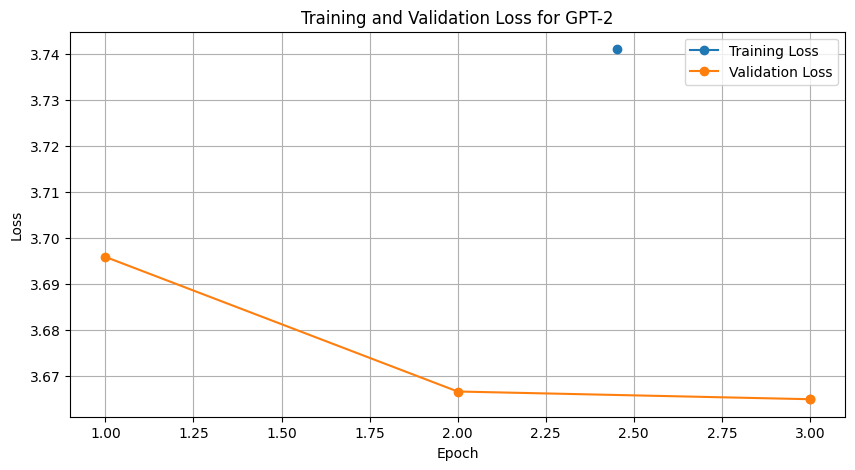

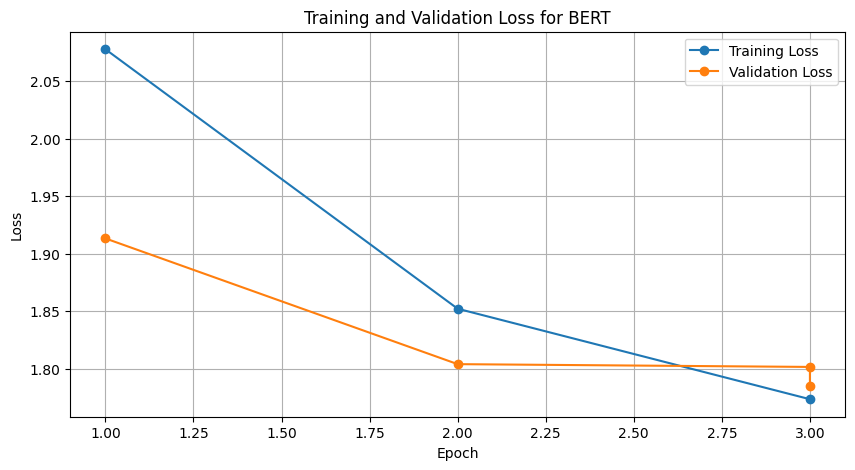

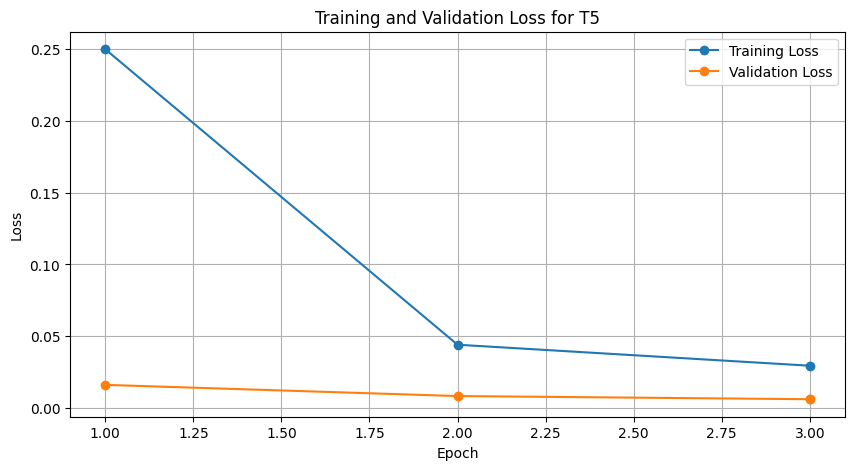

In [64]:

# --- Visualization of Training ---
def plot_loss_curves(trainer_history, model_name):
    train_logs = [log for log in trainer_history if 'loss' in log]
    eval_logs = [log for log in trainer_history if 'eval_loss' in log]

    if not train_logs or not eval_logs:
        print(f"Not enough log data to plot for {model_name}.")
        return

    plt.figure(figsize=(10, 5))
    plt.plot([log['epoch'] for log in train_logs], [log['loss'] for log in train_logs], marker='o', linestyle='-', label="Training Loss")
    plt.plot([log['epoch'] for log in eval_logs], [log['eval_loss'] for log in eval_logs], marker='o', linestyle='-', label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training and Validation Loss for {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

print("\nPlotting loss curves...")
plot_loss_curves(trainer.state.log_history, "GPT-2")
plot_loss_curves(trainer_bert.state.log_history, "BERT")
plot_loss_curves(trainer_t5.state.log_history, "T5")
